In [ ]:
# !nvidia-smi

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.preprocessing.image import ImageDataGenerator, load_img
# from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.models import Model
# from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras import backend
from keras.utils import plot_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout
from keras.models import Sequential
import matplotlib.pyplot as plt
from glob import glob
import os

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# Declarations
train_path = '../input/tomato/New Plant Diseases Dataset(Augmented)/train'
test_path = '../input/tomato/New Plant Diseases Dataset(Augmented)/valid'

# re-size all the images to this
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 32
EPOCHS = 10
RANDOM_SEED = 42

if backend.image_data_format() == 'channels_first':
    INPUT_SHAPE = (3, IMAGE_SIZE[0], IMAGE_SIZE[1])
else:
    INPUT_SHAPE = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

print(f'input_shape: {INPUT_SHAPE}')

# useful for getting number of output classes
count_of_classes = len(glob(train_path+'/*'))
print(count_of_classes)

input_shape: (224, 224, 3)
10


In [4]:
# Prepare train/test using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [5]:
#### conventional read

# labels = {
#     'healthy': 0,
#     'Late_blight': 1,
#     'Early_blight': 2,
#     'Septoria_leaf_spot': 3,
#     'Tomato_Yellow_Leaf_Curl_Virus': 4,
#     'Bacterial_spot': 5,
#     'Target_Spot': 6,
#     'Tomato_mosaic_virus': 7,
#     'Leaf_Mold': 8,
#     'Spider_mites Two-spotted_spider_mite': 9
# }
# labels_inv = dict((y,x) for x,y in labels.items())

# X_train = []
# y_train = []
# X_test = []
# y_test = []

# # read train data
# for train_class_path in glob(train_path+'/*'):
#     class_label = labels[train_class_path.split('___')[1]]
#     print(f': Reading {train_class_path} images')
#     for img in glob(train_class_path+'/*'):
#         img = load_img(img, color_mode='rgb', target_size=IMAGE_SIZE)
#         X_train.append(np.array(img))
#         y_train.append(class_label)

# # read test data
# for test_class_path in glob(test_path+'/*'):
#     class_label = labels[test_class_path.split('___')[1]]
#     print(f': Reading {test_class_path} images')
#     for img in glob(test_class_path+'/*'):
#         img = load_img(img, color_mode='rgb', target_size=IMAGE_SIZE)
#         X_test.append(np.array(img))
#         y_test.append(class_label)

# X_train = np.array(X_train)
# y_train = np.array(y_train)
# X_test = np.array(X_test)
# y_test = np.array(y_test)
# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# training_set = train_datagen.flow(x=X_train,
#                    y=y_train,
#                    batch_size=BATCH_SIZE, seed=RANDOM_SEED)

# test_set = test_datagen.flow(x=X_test,
#                    y=y_test,
#                    batch_size=BATCH_SIZE, seed=RANDOM_SEED)

In [6]:
#### read directly from directories
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = tuple(IMAGE_SIZE),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = tuple(IMAGE_SIZE),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical')

Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.


In [7]:
# Target class labels
labels_inv = dict((y,x) for x,y in training_set.class_indices.items())
labels_inv

{0: 'Tomato___Bacterial_spot',
 1: 'Tomato___Early_blight',
 2: 'Tomato___Late_blight',
 3: 'Tomato___Leaf_Mold',
 4: 'Tomato___Septoria_leaf_spot',
 5: 'Tomato___Spider_mites Two-spotted_spider_mite',
 6: 'Tomato___Target_Spot',
 7: 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 8: 'Tomato___Tomato_mosaic_virus',
 9: 'Tomato___healthy'}

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


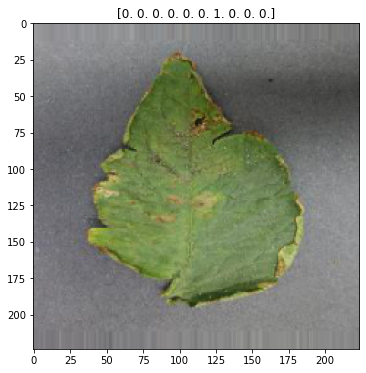

In [8]:
data, label = training_set.next()

plt.figure(figsize=(6, 6))
plt.imshow(data[4])
plt.title(label[2])
plt.show()

In [9]:
# Here we will be using imagenet weights

vgg16 = VGG16(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 2s 0us/step


In [10]:
# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

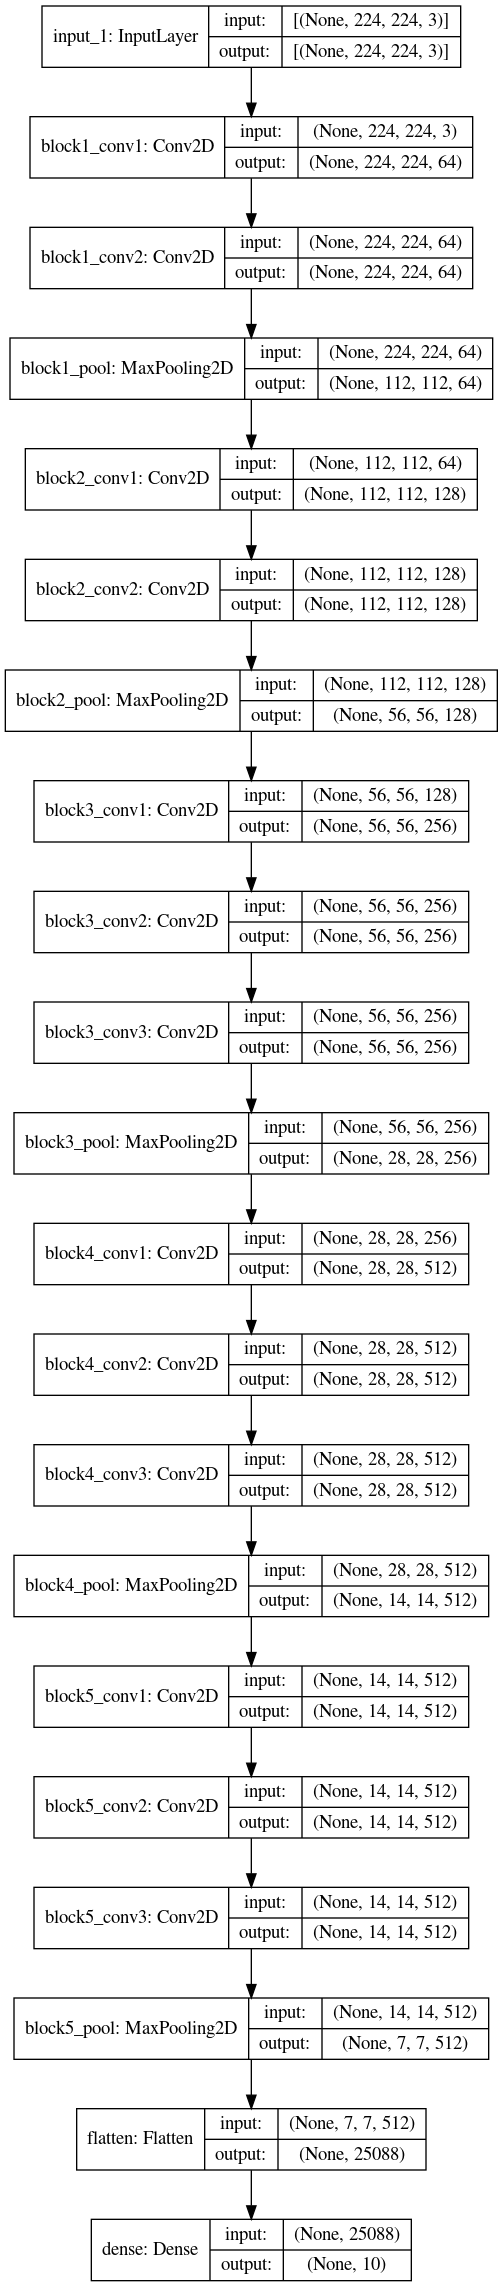

In [11]:
# our layers - you can add more if you want
x = Flatten()(vgg16.output)

prediction = Dense(count_of_classes, activation='softmax')(x)

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')
plot_model(model, show_shapes=True)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# fit the model

### using generator
history = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=EPOCHS,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
574/574 [==============================] - 384s 663ms/step - loss: 1.1054 - accuracy: 0.6509 - val_loss: 0.5372 - val_accuracy: 0.8172
Epoch 2/10
574/574 [==============================] - 225s 392ms/step - loss: 0.4069 - accuracy: 0.8614 - val_loss: 0.3743 - val_accuracy: 0.8750
Epoch 3/10
574/574 [==============================] - 226s 393ms/step - loss: 0.3242 - accuracy: 0.8916 - val_loss: 0.3769 - val_accuracy: 0.8700
Epoch 4/10
574/574 [==============================] - 227s 395ms/step - loss: 0.2788 - accuracy: 0.9041 - val_loss: 0.3853 - val_accuracy: 0.8757
Epoch 5/10
288/574 [==============>...............] - ETA: 1:47 - loss: 0.2421 - accuracy: 0.9193

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.show()
plt.savefig('Loss over Epochs')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show()
plt.savefig('Accuracy over Epochs')

In [ ]:
model.save('model_vgg16.h5')